### Packages

In [4]:
import pandas as pd
import numpy as np 
import io

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score

#from google.colab import files
#from google.colab import drive

### Uplaoding from drive is so much faster

In [3]:
#drive.mount('/content/drive')

In [5]:
df_train = pd.read_csv('data_train_mod.csv',index_col=0)
df_test = pd.read_csv('data_test_mod.csv',index_col=0)
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)


### Data Structure
Original data is like this: each row contains data for the trajectory of a device, including its unique ID, device ID, time of entry, time of exit, maximum velocity (Vmax), minimum velocity (Vmin), average velocity (Vmean), entry coordinates (x_entry, y_entry) and exit coordinates (X_exit, u_exit). For example:


---


Unnamed: 0                                                       0

hash                    0000a8602cf2def930488dee7cdad104_1

trajectory_id    traj_0000a8602cf2def930488dee7cdad104_1_0

time_entry                                        07:04:31

time_exit                                         07:08:32

vmax                                                   NaN

vmin                                                   NaN

vmean                                                  NaN

x_entry                                        3.75101e+06

y_entry                                        -1.9094e+07

x_exit                                         3.75033e+06

y_exit                                        -1.91363e+07

Name: 0, dtype: object


---



**Aim is to predict for the test data, for each device for the last trajectory, whether it's in the city region or not. (city region: x: (3750901.5068,3770901.5068), y:(-19268905.6133,-19208905.6133)) **

**We deleted the vmin, vmax, vmean and put in new data, veocity and time difference: ** 



---
hash                                0000a8602cf2def930488dee7cdad104_1

trajectory_id               traj_0000a8602cf2def930488dee7cdad104_1_0

time_entry                                         7:04:31

time_exit                                          7:08:32

vel1                                                175.79

time_diff1                                             241

vel2                                               257.946

time_diff2                                             722

x_entry                                        3.75101e+06

y_entry                                        -1.9094e+07

x_exit                                         3.75033e+06

y_exit                                        -1.91363e+07


---





In [108]:
print(df_train.loc[0])

hash                    0000a8602cf2def930488dee7cdad104_1
trajectory_id    traj_0000a8602cf2def930488dee7cdad104_1_0
time_entry                                           25471
time_exit                                            25712
vel1                                                175.79
time_diff1                                             241
vel2                                               257.946
time_diff2                                             722
x_entry                                        3.75101e+06
y_entry                                        -1.9094e+07
x_exit                                         3.75033e+06
y_exit                                        -1.91363e+07
Name: 0, dtype: object


## Trying multi-output regressors

### filling nan with 0 and converting time string in number

In [6]:
df_train_mulr = df_train.loc[0:2004]
df_test_mulr = df_train.loc[2004:3003]
# trying with very small dataset
#df_train_mulr = df_train_mulr.fillna(0)
#df_test_mulr = df_test_mulr.fillna(0)

### stacking the inputs together

In [10]:
max_length = max(df_train.groupby("hash").nunique()["trajectory_id"])*10-2
def stacking(df):
  df = df.drop('trajectory_id',axis = 1)
  grouped = df.groupby('hash')
  X = np.empty((1,max_length))
  y = np.empty((1,2))

  for name, group in grouped:
    hash_ = np.array([[]])
    #df_hash = df.loc[df['hash'] == name]    
    group = group.drop('hash', axis = 1)
    for index, row in group.iterrows():
      hash_ = np.append(hash_,np.array([row[:]]))
  
    y = np.r_[y,np.array([hash_[np.shape(hash_)[0]-2:np.shape(hash_)[0]]])] # putting the output away
    hash_ = np.delete(hash_,[np.shape(hash_)[0]-2,np.shape(hash_)[0]-1]) # removing the output
  
    num_pad = max_length - np.shape(hash_)[0] # padding with 0s
    hash_ = np.append(hash_,np.zeros(num_pad))
  
    X = np.r_[X,np.array([hash_])] # changing dimemsions of hash_

  y = np.delete(y, 0, 0)
  X = np.delete(X, 0, 0)
  
  return X, y


In [11]:
# training data
print(max_length)
X_mulr, y_mulr = stacking(df_train_mulr)
print(np.shape(X_mulr)); print(np.shape(y_mulr))
#print(X_mulr[0]); print(y_mulr[0])

198
(333, 198)
(333, 2)


In [12]:
# testing data with output
X_test, y_test = stacking(df_test_mulr)
#print(np.shape(X_test)); print(np.shape(y_test))

In [13]:
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,max_depth=30,random_state=0))
regr_multirf.fit(X_mulr, y_mulr)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)

In [14]:
def city(y):
  city = np.array([[]])
  for i in range(np.shape(y)[0]):
    if y[i][0] > 3750901.5068 and y[i][0] < 3770901.5068 and y[i][1] > -19268905.6133 and y[i][1] < -19208905.6133:
      city = np.append(city,1)
    else:
      city = np.append(city,0)
  return city
  

In [15]:
# accuracy 
print (classification_report(city(y_test), city(y_multirf),digits = 4))
print (confusion_matrix(city(y_test), city(y_multirf)))
print (accuracy_score(city(y_test), city(y_multirf)))

             precision    recall  f1-score   support

        0.0     0.8595    0.8320    0.8455       125
        1.0     0.5962    0.6458    0.6200        48

avg / total     0.7864    0.7803    0.7830       173

[[104  21]
 [ 17  31]]
0.7803468208092486


<Figure size 432x288 with 0 Axes>

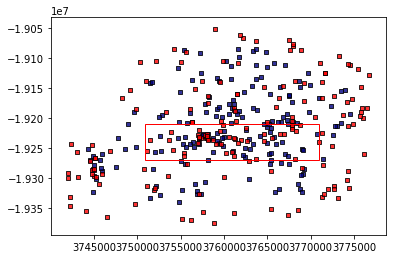

In [16]:
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [0]:
# downloading results
df = pd.DataFrame(city(y_multirf))
df.to_csv('df.csv')
files.download('df.csv')

## Putting everything together

In [3]:
def stacking(df):
  df = df.drop('trajectory_id',axis = 1)
  grouped = df.groupby('hash')
  X = np.empty((1,max_length))
  y = np.empty((1,2))

  for name, group in grouped:
    hash_ = np.array([[]])
    #df_hash = df.loc[df['hash'] == name]
    group = group.drop('hash', axis = 1)
    for index, row in group.iterrows():
        hash_ = np.append(hash_,np.array([row[:]]))
  
    y = np.r_[y,np.array([hash_[np.shape(hash_)[0]-2:np.shape(hash_)[0]]])] # putting the output away
    hash_ = np.delete(hash_,[np.shape(hash_)[0]-2,np.shape(hash_)[0]-1]) # removing the output
  
    num_pad = max_length - np.shape(hash_)[0] # padding with 0s
    hash_ = np.append(hash_,np.zeros(num_pad))
  
    X = np.r_[X,np.array([hash_])] # changing dimemsions of hash_

  y = np.delete(y, 0, 0)
  X = np.delete(X, 0, 0)
  
  return X, y


def stacking_no_y(df):
  df = df.drop('trajectory_id',axis = 1)
  grouped = df.groupby('hash')
  X = np.empty((1,max_length))

  for name, group in grouped:
    hash_ = np.array([[]])
    #df_hash = df.loc[df['hash'] == name]
    group = group.drop('hash', axis = 1)
    for index, row in group.iterrows():
        hash_ = np.append(hash_,np.array([row[:]]))

    num_pad = max_length - np.shape(hash_)[0] # padding with 0s
    hash_ = np.append(hash_,np.zeros(num_pad))
  
    X = np.r_[X,np.array([hash_])] # changing dimemsions of hash_

  X = np.delete(X, 0, 0)
  return X


def city(y):
  city = np.array([[]])
  for i in range(np.shape(y)[0]):
    if y[i][0] > 3750901.5068 and y[i][0] < 3770901.5068 and y[i][1] > -19268905.6133 and y[i][1] < -19208905.6133:
      city = np.append(city,1)
    else:
      city = np.append(city,0)
  return city



### trying with other small dataset

             precision    recall  f1-score   support

        0.0     0.8897    0.7933    0.8388      1200
        1.0     0.5887    0.7505    0.6599       473

avg / total     0.8046    0.7812    0.7882      1673

[[952 248]
 [118 355]]
0.7812313209802749


<Figure size 432x288 with 0 Axes>

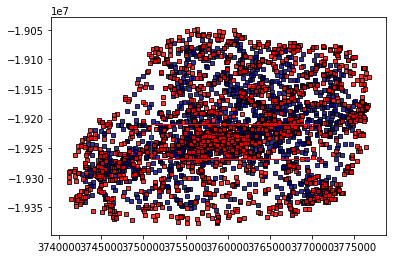

In [4]:
max_length = max(df_train.groupby("hash").nunique()["trajectory_id"])*10-2
df_train_mulr = df_train.loc[0:4000]
df_test_mulr = df_train.loc[10001:20001]
# trying with very small dataset

df_train_mulr = df_train_mulr.fillna(0)
df_test_mulr = df_test_mulr.fillna(0)

X_mulr, y_mulr = stacking(df_train_mulr)
X_test, y_test = stacking(df_test_mulr)

regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=200,max_depth=100,random_state=0))
regr_multirf.fit(X_mulr, y_mulr)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)


# accuracy 
print (classification_report(city(y_test), city(y_multirf),digits = 4))
print (confusion_matrix(city(y_test), city(y_multirf)))
print (accuracy_score(city(y_test), city(y_multirf)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [5]:
regr_multigbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=200,max_depth=100,random_state=0))
regr_multigbr.fit(X_mulr, y_mulr)

# Predict on new data
y_multigbr = regr_multigbr.predict(X_test)


# accuracy 
print (classification_report(city(y_test), city(y_multigbr),digits = 4))
print (confusion_matrix(city(y_test), city(y_multigbr)))


             precision    recall  f1-score   support

        0.0     0.8484    0.8625    0.8554      1200
        1.0     0.6358    0.6089    0.6220       473

avg / total     0.7883    0.7908    0.7894      1673

[[1035  165]
 [ 185  288]]


### downloading the flatten dataframe for future use

### stacking by chunks
https://stackoverflow.com/questions/31655634/pandas-groupy-take-only-the-first-n-groups

In [1]:
def stacking(groups):
    X_group = np.empty(shape=[0, max_length])
    y_group = np.empty(shape=[0, 2])
    for i in range(len(groups)):
        hash_ = np.array([[]])
        group = groups[i]
        group = group.drop('hash', axis = 1)
        for index, row in group.iterrows():
            hash_ = np.append(hash_,np.array([row[:]]))
  
        y_group = np.r_[y_group,np.array([hash_[np.shape(hash_)[0]-2:np.shape(hash_)[0]]])] # putting the output away
        hash_ = np.delete(hash_,[np.shape(hash_)[0]-2,np.shape(hash_)[0]-1]) # removing the output
  
        num_pad = max_length - np.shape(hash_)[0] # padding with 0s
        hash_ = np.append(hash_,np.zeros(num_pad))
  
        X_group = np.r_[X_group,np.array([hash_])] # changing dimemsions of hash_
    return X_group, y_group


def stacking_by_chunks(df):
    df = df.drop('trajectory_id',axis = 1)
    grouped = df.groupby('hash')
    X = np.empty(shape=[0, max_length])
    y = np.empty(shape=[0, 2])  
    num_groups = grouped['hash'].unique().count()
    num_iter = 100
    chunk_size = int(num_groups/num_iter)
    #last_chunk = num_groups - chunk_size*num_iter
    
    for i in range(1,num_iter+1):
        groups = [g[1] for g in list(grouped)[(i-1)*chunk_size:i*chunk_size]]
        X_group, y_group = stacking(groups)
        X = np.r_[X,X_group]
        y = np.r_[y,y_group]
    
    groups = [g[1] for g in list(grouped)[num_iter*chunk_size:num_groups]] 
    #last chunk
    X_group, y_group = stacking(groups)
    X = np.r_[X,X_group]
    y = np.r_[y,y_group]
    
    return X,y

def city(y):
    city = np.array([[]])
    for i in range(np.shape(y)[0]):
        if y[i][0] > 3750901.5068 and y[i][0] < 3770901.5068 and y[i][1] > -19268905.6133 and y[i][1] < -19208905.6133:
            city = np.append(city,1)
        else:
            city = np.append(city,0)
    return city  

def stacking_no_y_left(df):
    df = df.drop('trajectory_id',axis = 1)
    grouped = df.groupby('hash')
    X = np.empty((1,max_length))

    for name, group in grouped:
        hash_ = np.array([[]])
        group = group.drop('hash', axis = 1)
        for index, row in group.iterrows():
            hash_ = np.append(hash_,np.array([row[:]]))

    num_pad = max_length - np.shape(hash_)[0] # padding with 0s
    hash_ = np.append(np.zeros(num_pad),hash_)
  
    X = np.r_[X,np.array([hash_])] # changing dimemsions of hash_

      X = np.delete(X, 0, 0)
  return X


In [164]:
max_length = max(df_train.groupby("hash").nunique()["trajectory_id"])*10-2
df_train_mulr = df_train
df_train_mulr = df_train_mulr.fillna(0)

X_train, y_train = stacking_by_chunks(df_train_mulr)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')
#files.download('X_train.csv')
#files.download('y_train.csv')


In [166]:
df_train.groupby("hash")['hash'].unique().count()
#print(X_train.loc[0])

134063

In [6]:
max_length = max(df_train.groupby("hash").nunique()["trajectory_id"])*10-2
df_test_mulr = df_test
df_test_mulr = df_test_mulr.fillna(0)

X_test_left = stacking_no_y_left(df_test_mulr)
X_test_left = pd.DataFrame(X_test_left)
X_test_left.to_csv('X_test_left.csv')
#files.download('X_test.csv')

ValueError: negative dimensions are not allowed

In [160]:
df_test.groupby("hash")['hash'].unique().count()

33515

## Different models

In [11]:
X_train = pd.read_csv('X_train.csv',index_col=0)
y_train = pd.read_csv('y_train.csv',index_col=0)

X_train = pd.DataFrame(X_train.loc[0:2000])
y_train = pd.DataFrame(y_train.loc[0:2000])

In [14]:
# spliting test/train data 
train_size = int(0.8*np.shape(X_train)[0])
test_size = np.shape(X_train)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, train_size=train_size, test_size=test_size, random_state=4)


# random forest
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=200,max_depth=100,random_state=0,verbose=True))
regr_multirf.fit(X_train, y_train)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)

# accuracy 
print (classification_report(city(y_test), city(y_multirf),digits = 4))
print (confusion_matrix(city(y_test), city(y_multirf)))
print (accuracy_score(city(y_test), city(y_multirf)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.9s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


KeyError: 0

In [ ]:
# gradient boosting 
regr_multigbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=200,max_depth=100,random_state=0))
regr_multigbr.fit(X_mulr, y_mulr)

# Predict on new data
y_multigbr = regr_multigbr.predict(X_test)


## using minibatch

In [0]:
from sklearn.linear_model import SGDRegressor
 
def iter_minibatches(chunksize):
    # Provide chunks one by one
  chunkstartmarker = 0
  while chunkstartmarker < numtrainingpoints:
    chunkrows = range(chunkstartmarker,chunkstartmarker+chunksize)
    X_chunk, y_chunk = getrows(chunkrows)
    yield X_chunk, y_chunk
    chunkstartmarker += chunksize

def main():
  batcherator = iter_minibatches(chunksize=1000)
  model = SGDRegressor()
 # Train model
  for X_chunk, y_chunk in batcherator:
    model.partial_fit(X_chunk, y_chunk)
 # Now make predictions with trained model
  y_predicted = model.predict(X_test)

### fitting ey test data with no output

In [0]:
X_test = pd.read_csv('X_test.csv',index_col=0)
X_test = pd.DataFrame(X_test)
y_multi = regr_multirf.predict(X_test)
# downloading results
result = pd.DataFrame(city(y_multi))
result.to_csv('result.csv')